<a href="https://colab.research.google.com/github/ensiferum877/pd-scrna-seq-analysis/blob/dev%2Fpreprocessing-notebook/notebooks/Output_Biomni_PD_scRNAseq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 1: Quality Control & Preprocessing

## Overview
This notebook demonstrates a systematic approach to quality control and preprocessing
of single-cell RNA-seq data. Starting from **raw count matrices**, we'll filter low-quality cells and prepare a clean dataset for downstream analysis.

## What You'll Learn
- Calculation of standard QC metrics
- Data-driven filtering strategies with biological justification
- Normalization method selection and implementation
- Best practices for preprocessing reproducibility

## Input & Output
**Input:** Raw count matrix from 10X Genomics CellRanger output  
**Output:** Filtered and normalized AnnData object ready for dimensionality reduction

## Prerequisites
For dataset background and biological context, see the [main README](../README.md).

#1 INSTALLING PACKAGES


In [1]:
! pip install scanpy scrublet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 43.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 100.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.2/174.2 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.1/284.1 kB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 158.0 MB/s eta 0:00:00
  Created wheel for annoy: filename=annoy-1.17.3-cp312-cp312-linux_x86_64.whl size=549282 sha256=7bf5503f8d3344453797c1736fb4c3d1fdd1746f5ba41d5ba0d4ee7dbb819d11
  Stored in directory: /root/.cache/pip/wheels/db/b9/53/a3b2d1fe1743abadddec6aa541294b24fdbc39d7800bc57311
Successfully built annoy


#2  IMPORTING PACKAGES

In [2]:
import os
from typing import Tuple
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import scrublet as scr
from IPython.display import display, HTML
import warnings
warnings.filterwarnings('ignore')

# 3 CONFIGURATION & QUALITY CONTROL STRATEGY

## Overview

This section defines all quality control parameters and filtering thresholds used throughout this notebook. The configuration is structured to balance:

1. **Reproducibility:** All parameters explicitly defined and version-controlled
2. **Adaptability:** Percentile-based thresholds adjust to dataset characteristics

## Configuration Structure

Parameters organized by analytical stage:
1. **Doublet Detection:** Scrublet-specific parameters based on 10X Chromium specifications
2. **Gene Patterns:** Species-specific markers for QC metric calculation
3. **Adaptive QC:** Percentile-based thresholds for filtering
4. **Quality Warnings:** Absolute thresholds flagging systematic issues
5. **Gene Filtering:** Minimum detection requirements


In [3]:
# ==========================================
# PREPROCESSING CONFIGURATION
# ==========================================
# Note: Class-based structure enables easy extraction to external config files
# for production deployment while maintaining notebook self-containment

class PreprocessingConfig:
    """
    Comprehensive quality control configuration for PBMC scRNA-seq preprocessing.

    Design Rationale:
    -----------------
    - Adaptive thresholds: Percentile-based to handle biological variability
    - Quality guardrails: Absolute checks for systematic issues
    - Technology-specific: Parameters tuned for 10X Chromium platform
    - PBMC-optimized: Thresholds reflect expected immune cell characteristics

    Usage:
    ------
    config = PreprocessingConfig()
    min_genes_threshold = np.percentile(adata.obs['n_genes'], config.QCThresholds.MIN_GENES_PCTL)
    """

    # ==========================================
    # PATHS (Modify for your environment)
    # ==========================================
    class Paths:
        """
        Data paths for input/output.

        Note: Adjust these paths based on your execution environment:
        - Google Colab: /content/drive/MyDrive/...
        - Local: /path/to/your/data/
        - HPC cluster: /scratch/username/...
        """
        DATA_DIR = '/content/drive/MyDrive/GSE223138_h5ad'
        OUTPUT_DIR = '/content/drive/MyDrive/Stage1_results'

    # ==========================================
    # DOUBLET DETECTION (Scrublet)
    # ==========================================
    class Scrublet:
        """
        Scrublet parameters for doublet detection.

        Rationale:
        - EXPECTED_DOUBLET_RATE: 8% based on 10X Chromium specification
          for standard loading (~5,000 cells/lane). Higher rates indicate
          overloading or aggregation issues.
        - MIN_GENE_VAR_PCTL: 85th percentile focuses on biologically
          informative genes, reducing noise from lowly-expressed genes
        - N_PC: 30 PCs balances capturing biological variation vs.
          computational efficiency for doublet simulation
        """
        EXPECTED_DOUBLET_RATE = 0.08       # 8% expected for 10X standard loading
        MIN_COUNTS = 2                     # Minimum UMI counts for simulation
        MIN_CELLS = 3                      # Minimum cells expressing a gene
        MIN_GENE_VAR_PCTL = 85             # Use top 15% most variable genes
        N_PC = 30                          # PCA components for doublet space

    # ==========================================
    # GENE PATTERNS (Human-specific)
    # ==========================================
    class GenePatterns:
        """
        Gene name patterns for QC metric calculation.

        Biological Significance:
        - MT genes: High % indicates apoptosis, necrosis, or damaged cells
        - Ribosomal genes: Can indicate RNA degradation or cell stress
        - Hemoglobin: Specific to RBC contamination in PBMC isolations

        Note: Patterns are human genome-specific (GRCh38/hg38)
        """
        MT_PREFIX = 'MT-'                         # Mitochondrial genes
        RIBO_PREFIXES = ('RPS', 'RPL')           # Ribosomal protein genes
        HB_PATTERN = '^HB[^(P)]'                 # Hemoglobin (excludes HBP - heparin-binding protein)

    # ==========================================
    # ADAPTIVE QC THRESHOLDS (Percentile-based)
    # ==========================================
    class QCThresholds:
        """
        Percentile-based filtering thresholds.

        Design Philosophy:
        - Remove extreme outliers (5th/95th percentiles) rather than fixed cutoffs
        - Preserves biological variation while eliminating technical failures
        - Adapts to dataset-specific quality distributions

        Interpretation:
        - MIN_GENES_PCTL=5: Cells in bottom 5% likely empty droplets or debris
        - MAX_GENES_PCTL=95: Cells in top 5% likely doublets or multiplets
        - MAX_MT_PCTL=99: Only remove most extreme cases (1%) to avoid
          discarding stressed but viable immune cells (e.g., activated T cells)
        """
        MIN_GENES_PCTL = 5                # Remove bottom 5% (empty droplets)
        MAX_GENES_PCTL = 95               # Remove top 5% (potential doublets)
        MIN_COUNTS_PCTL = 5               # Remove low-count outliers
        MAX_COUNTS_PCTL = 95              # Remove high-count outliers
        MAX_MT_PCTL = 99                  # Conservative: only extreme cases (1%)
        MAX_HB_PCTL = 95                  # Remove RBC contamination outliers

    # ==========================================
    # QUALITY WARNING THRESHOLDS (Absolute)
    # ==========================================
    class Warnings:
        """
        Absolute thresholds for dataset quality assessment.

        These flag systematic issues that percentile filtering cannot detect.
        Based on expected PBMC characteristics from literature and technical specs.

        Threshold Justification:
        ------------------------
        MAX_DOUBLET_PCT (20%):
            - 10X spec: ~8% expected
            - >20% suggests overloading or cell aggregation
            - Compromises downstream cell type annotation

        MIN_CELL_RETENTION_PCT (60%):
            - <60% retention indicates poor sample quality
            - May reflect degraded RNA, improper handling, or unsuitable tissue

        MIN_MEDIAN_GENES (500):
            - Healthy PBMCs: 500-2000 genes/cell (Zheng et al., 2017)
            - <500 suggests RNA degradation or failed library prep

        MAX_MEDIAN_MT_PCT (15%):
            - Healthy immune cells: typically 5-15% mitochondrial content
            - >15% indicates cellular stress or dissociation artifacts
            - Caveat: Activated T cells may naturally have elevated MT%

        MAX_MEDIAN_HB_PCT (10%):
            - PBMC isolation should remove RBCs via density gradient
            - >10% HB+ cells indicates contamination or lysis
            - Common issue: incomplete RBC lysis or improper centrifugation
        """
        MAX_DOUBLET_PCT = 20.0            # Alert if >20% doublets detected
        MIN_CELL_RETENTION_PCT = 60       # Alert if <60% cells pass QC
        MIN_MEDIAN_GENES = 500            # Minimum expected genes/cell
        MAX_MEDIAN_MT_PCT = 15.0          # Maximum acceptable mitochondrial %
        MAX_MEDIAN_HB_PCT = 10.0          # Maximum acceptable hemoglobin %

    # ==========================================
    # GENE FILTERING
    # ==========================================
    MIN_CELLS_PER_GENE = 10
    """
    Remove genes detected in <10 cells.

    Rationale:
    - Genes in <10 cells likely technical noise or ambient RNA
    - Reduces dimensionality without losing biological information
    - Standard practice: 0.1-0.5% of cells (for 2000+ cell datasets)
    """

# 4 DATA LOADING & SAMPLE METADATA EXTRACTION

Load raw `.h5ad` files and extract sample-level metadata for downstream tracking such as:

- Number of samples,
- Total number of cells, etc


In [4]:
# Find all .h5ad files
config = PreprocessingConfig()
h5ad_dir = config.Paths.DATA_DIR
h5ad_files = [f for f in os.listdir(h5ad_dir) if f.endswith('.h5ad')]

if len(h5ad_files) == 0:
    raise FileNotFoundError(f"No .h5ad files found in {h5ad_dir}")

print(f"Found {len(h5ad_files)} samples\n")

# Extract sample metadata
sample_info = []
for file in h5ad_files:
    adata_temp = sc.read_h5ad(os.path.join(h5ad_dir, file))
    sample_info.append({
        'file': file,
        'sample_id': adata_temp.obs['sample_id'].iloc[0],
        'condition': adata_temp.obs['condition'].iloc[0],
        'combined_condition': adata_temp.obs['combined_condition'].iloc[0],
        'stage': adata_temp.obs['stage'].iloc[0],
        'n_cells': adata_temp.n_obs,
        'n_genes': adata_temp.n_vars
    })

sample_df = pd.DataFrame(sample_info)

print("Sample Metadata:")
print(sample_df.to_string(index=False))

print(f"\nConditions: {sample_df['condition'].unique()}")
print(f"Combined conditions: {sample_df['combined_condition'].unique()}")
print(f"Stages: {sample_df['stage'].unique()}")

print(f"\nCondition Distribution:")
print(sample_df['condition'].value_counts())

# Store total samples for later
n_samples = len(sample_df)
n_cells_raw = sample_df['n_cells'].sum()
# Print the total number of samples and cells from the scRNA-seq experiment
print(f"\n✓ Loaded {n_samples} samples with {n_cells_raw} total cells")

Found 6 samples

Sample Metadata:
              file     sample_id condition combined_condition stage  n_cells  n_genes
GSM6940195_20.h5ad GSM6940195_20     Early           Early-PD    PD     9838    36601
GSM6940196_25.h5ad GSM6940196_25  Advanced        Advanced-PD    PD    10470    36601
GSM6940193_17.h5ad GSM6940193_17    Normal           Normal-1     1     8721    36601
GSM6940192_16.h5ad GSM6940192_16    Normal           Normal-1     1    12190    36601
GSM6940197_26.h5ad GSM6940197_26  Advanced        Advanced-PD    PD    10339    36601
GSM6940194_19.h5ad GSM6940194_19  Advanced        Advanced-PD    PD    15268    36601

Conditions: ['Early' 'Advanced' 'Normal']
Combined conditions: ['Early-PD' 'Advanced-PD' 'Normal-1']
Stages: ['PD' '1']

Condition Distribution:
condition
Advanced    3
Normal      2
Early       1
Name: count, dtype: int64

✓ Loaded 6 samples with 66826 total cells


# 5 QUALITY CONTROL & FILTERING


## 5.2 Doublet Detection

   - Run Scrublet
   - Identify doublets
   - Remove doublets
   - Track counts

In [5]:
def apply_scrublet_to_sample(adata, sample_name):
    """
    Apply Scrublet doublet detection to a single sample.

    Parameters:
    -----------
    adata : AnnData
        Sample to process
    sample_name : str
        Sample identifier

    Returns:
    --------
    adata : AnnData with doublets removed
    n_doublets : Number of detected doublets
    doublet_rate : Fraction of cells identified as doublets
    """

    # Initialize Scrublet
    scrub = scr.Scrublet(
        adata.X,
        expected_doublet_rate=config.Scrublet.EXPECTED_DOUBLET_RATE
    )

    # Run doublet detection
    doublet_scores, predicted_doublets = scrub.scrub_doublets(
        min_counts=config.Scrublet.MIN_COUNTS,
        min_cells=config.Scrublet.MIN_CELLS,
        min_gene_variability_pctl=config.Scrublet.MIN_GENE_VAR_PCTL,
        n_prin_comps=config.Scrublet.N_PC
    )

    # Calculate statistics
    n_doublets = sum(predicted_doublets)
    doublet_rate = n_doublets / len(predicted_doublets)

    # Remove doublets
    adata_filtered = adata[~predicted_doublets].copy()

    return adata_filtered, n_doublets, doublet_rate


# Process all samples
print("Running doublet detection...")
print("="*60)

adatas_filtered = []
doublet_stats = []

for file in h5ad_files:
    adata = sc.read_h5ad(os.path.join(h5ad_dir, file))
    sample_name = adata.obs['sample_id'].iloc[0]

    # Apply Scrublet and remove doublets
    adata_filtered, n_doublets, doublet_rate = apply_scrublet_to_sample(
        adata,
        sample_name
    )

    adatas_filtered.append(adata_filtered)

    doublet_stats.append({
        'sample': sample_name,
        'condition': adata.obs['condition'].iloc[0],
        'stage': adata.obs['stage'].iloc[0],
        'cells_before': adata.n_obs,
        'doublets_removed': n_doublets,
        'doublet_rate': doublet_rate,
        'cells_after': adata_filtered.n_obs
    })

    print(f"✓ {sample_name}: {n_doublets} doublets removed ({doublet_rate:.1%})")

# Create summary
doublet_df = pd.DataFrame(doublet_stats)

print("\n" + "="*60)
print("DOUBLET DETECTION SUMMARY")
print("="*60)
print(doublet_df.to_string(index=False))

# Aggregate statistics
print("\n" + "="*60)
print("OVERALL IMPACT")
print("="*60)
print(f"Total samples:         {len(doublet_df)}")
print(f"Cells before:          {doublet_df['cells_before'].sum():,}")
print(f"Doublets removed:      {doublet_df['doublets_removed'].sum():,}")
print(f"Cells after:           {doublet_df['cells_after'].sum():,}")
print(f"Average doublet rate:  {doublet_df['doublet_rate'].mean():.1%}")
print(f"Range:                 {doublet_df['doublet_rate'].min():.1%} - {doublet_df['doublet_rate'].max():.1%}")

# Quality check
print("\n" + "="*60)
print("QUALITY ASSESSMENT")
print("="*60)

warnings_found = False
for _, row in doublet_df.iterrows():
    if row['doublet_rate'] * 100 > config.Warnings.MAX_DOUBLET_PCT:
        print(f"⚠️  WARNING: {row['sample']} doublet rate ({row['doublet_rate']:.1%}) "
              f"exceeds threshold ({config.Warnings.MAX_DOUBLET_PCT}%)")
        warnings_found = True

if not warnings_found:
    print("✓ All samples within acceptable doublet rate range")
    print(f"  Expected: ~{config.Scrublet.EXPECTED_DOUBLET_RATE*100:.0f}% "
          f"(10X specification)")
    print(f"  Observed: {doublet_df['doublet_rate'].mean():.1%} average")

print("="*60 + "\n")

# Store counts for final QC summary
n_doublets_total = doublet_df['doublets_removed'].sum()
n_after_doublets = doublet_df['cells_after'].sum()

# Concatenate filtered samples for next step
adata = sc.concat(adatas_filtered, label='sample')
print(f"✓ Combined {len(adatas_filtered)} samples: {adata.n_obs:,} cells remaining")

Running doublet detection...
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.29
Detected doublet rate = 5.9%
Estimated detectable doublet fraction = 55.5%
Overall doublet rate:
	Expected   = 8.0%
	Estimated  = 10.6%
Elapsed time: 14.1 seconds
✓ GSM6940195_20: 576 doublets removed (5.9%)
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.25
Detected doublet rate = 4.8%
Estimated detectable doublet fraction = 61.7%
Overall doublet rate:
	Expected   = 8.0%
	Estimated  = 7.8%
Elapsed time: 14.8 seconds
✓ GSM6940196_25: 503 doublets removed (4.8%)
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.25
Detected doublet rate = 6.7%
Estimated detectable doublet fraction = 63.2%
O

# 4 - QC AND PREPROCESSING

## 4.1 - Removing doublets

In [ ]:
# @title
# PHASE 2: QC AND PREPROCESSING
print("="*60)
print("PHASE 2: QUALITY CONTROL AND PREPROCESSING")
print("="*60)

# Remove doublets from each sample and concatenate
print("Removing detected doublets...")
adatas_clean = []

for i, adata in enumerate(adatas):
    sample_name = doublet_stats[i]['sample']
    print(f"Processing {sample_name}: removing {sum(adata.obs['predicted_doublet'])} doublets")

    # Filter out doublets
    adata_clean = adata[~adata.obs['predicted_doublet']].copy()
    adatas_clean.append(adata_clean)

# Concatenate all samples
print("\nConcatenating all samples...")
adata_concat = ad.concat(adatas_clean, join='outer', index_unique='-')

print(f"Combined data shape: {adata_concat.shape}")
print(f"Total cells: {adata_concat.n_obs}")
print(f"Total genes: {adata_concat.n_vars}")

# Add batch information (sample as batch)
adata_concat.obs['batch'] = adata_concat.obs['sample_id']

# Check the condition distribution
print(f"\nCondition distribution after doublet removal:")
print(adata_concat.obs['condition'].value_counts())

print(f"\nSample distribution:")
print(adata_concat.obs['sample_id'].value_counts())

PHASE 2: QUALITY CONTROL AND PREPROCESSING
Removing detected doublets...
Processing GSM6940195_20: removing 576 doublets
Processing GSM6940196_25: removing 503 doublets
Processing GSM6940193_17: removing 580 doublets
Processing GSM6940192_16: removing 752 doublets
Processing GSM6940197_26: removing 519 doublets
Processing GSM6940194_19: removing 966 doublets

Concatenating all samples...
Combined data shape: (62930, 36601)
Total cells: 62930
Total genes: 36601

Condition distribution after doublet removal:
condition
Advanced    34089
Normal      19579
Early        9262
Name: count, dtype: int64

Sample distribution:
sample_id
GSM6940194_19    14302
GSM6940192_16    11438
GSM6940196_25     9967
GSM6940197_26     9820
GSM6940195_20     9262
GSM6940193_17     8141
Name: count, dtype: int64


## 4.2 - Compute QC metrics

Calculating QC metrics...
Mitochondrial genes: 13
Ribosomal genes: 103
Hemoglobin genes: 12
QC metrics calculated!

Observation columns: ['sample_id', 'combined_condition', 'condition', 'stage', 'doublet_score', 'predicted_doublet', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb']

QC METRICS SUMMARY
n_genes_by_counts:
  Mean: 1196.13
  Median: 1194.00
  Std: 516.14
  Min: 17.00
  Max: 5985.00

total_counts:
  Mean: 3015.22
  Median: 2683.00
  Std: 1876.32
  Min: 500.00
  Max: 46457.00

pct_counts_mt:
  Mean: 3.06
  Median: 2.86
  Std: 1.82
  Min: 0.00
  Max: 96.91

pct_counts_ribo:
  Mean: 25.11
  Median: 25.00
  Std: 10.95
  Min: 0.02
  Max: 61.63

pct_counts_hb:
  Mean: 5.34
  Median: 0.04
  Std: 21.61
  Min: 0.00
  Max: 99.02

Creating QC plots...


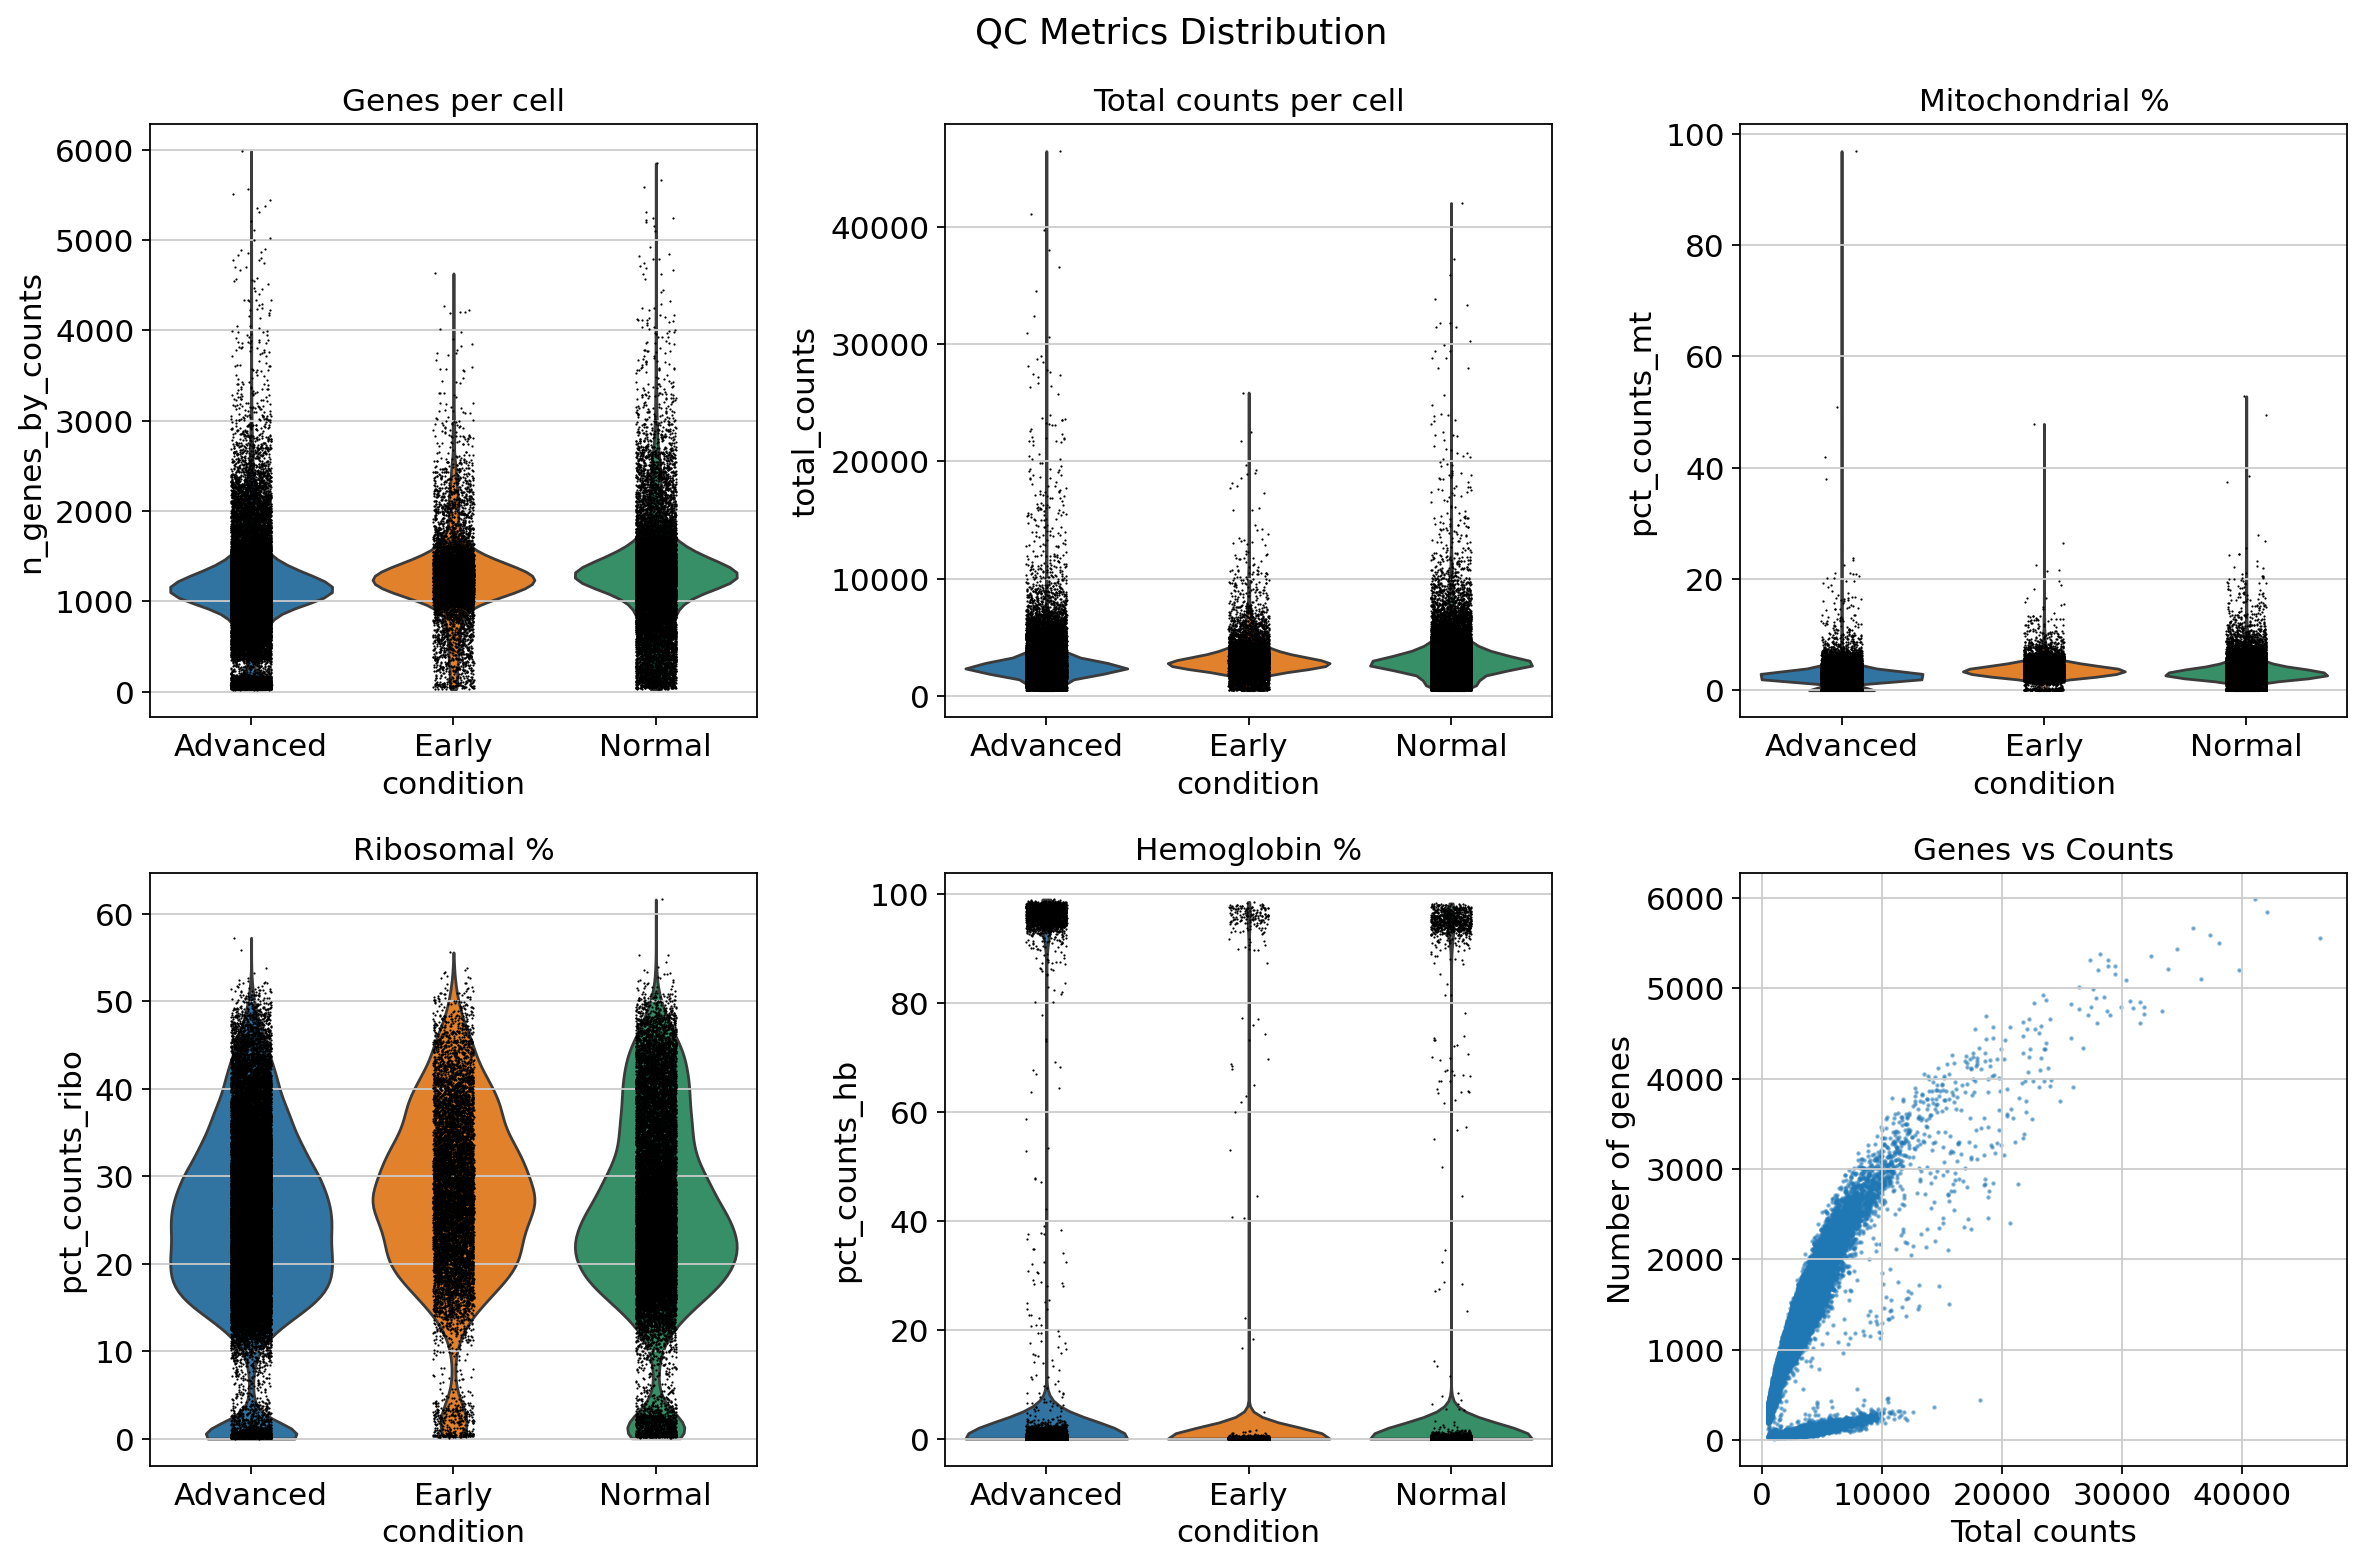


FILTERING THRESHOLD RECOMMENDATIONS
Based on data distribution:
n_genes_by_counts:
  5th percentile: 208
  95th percentile: 2080
total_counts:
  5th percentile: 993
  95th percentile: 5850
pct_counts_mt:
  95th percentile: 5.69%
  99th percentile: 8.98%
pct_counts_hb:
  95th percentile: 93.11%
  99th percentile: 97.45%


In [ ]:
# @title
# Let me fix the var_names_unique issue and continue with QC
print("Calculating QC metrics...")

# Make sure we have unique gene names
adata_concat.var.index = adata_concat.var.index.astype(str)

# Check for duplicates and make unique if needed
if not adata_concat.var.index.is_unique:
    print("Making gene names unique...")
    adata_concat.var_names_unique()

# Calculate QC metrics using Configured Patterns
# Mitochondrial genes
adata_concat.var['mt'] = adata_concat.var_names.str.startswith(MT_PREFIX)
# Ribosomal genes
adata_concat.var['ribo'] = adata_concat.var_names.str.startswith(RIBO_PREFIXES)
# Hemoglobin genes
adata_concat.var['hb'] = adata_concat.var_names.str.contains(HB_PATTERN)

print(f"Mitochondrial genes: {sum(adata_concat.var['mt'])}")
print(f"Ribosomal genes: {sum(adata_concat.var['ribo'])}")
print(f"Hemoglobin genes: {sum(adata_concat.var['hb'])}")

# Calculate basic QC metrics
sc.pp.calculate_qc_metrics(adata_concat, percent_top=None, log1p=False, inplace=True)

# Calculate mitochondrial, ribosomal, and hemoglobin percentages
sc.pp.calculate_qc_metrics(adata_concat, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(adata_concat, qc_vars=['ribo'], percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(adata_concat, qc_vars=['hb'], percent_top=None, log1p=False, inplace=True)

print("QC metrics calculated!")

# Check what columns we have
print(f"\nObservation columns: {adata_concat.obs.columns.tolist()}")

# Display QC summary statistics for available metrics
available_qc_metrics = ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb']

print(f"\n{'='*60}")
print("QC METRICS SUMMARY")
print(f"{'='*60}")

for metric in available_qc_metrics:
    if metric in adata_concat.obs.columns:
        print(f"{metric}:")
        print(f"  Mean: {adata_concat.obs[metric].mean():.2f}")
        print(f"  Median: {adata_concat.obs[metric].median():.2f}")
        print(f"  Std: {adata_concat.obs[metric].std():.2f}")
        print(f"  Min: {adata_concat.obs[metric].min():.2f}")
        print(f"  Max: {adata_concat.obs[metric].max():.2f}")
        print()
    else:
        print(f"{metric}: Not available")

# --- WARNING CHECKS FOR RAW DATA ---
print(f"\n{'='*60}")
print("RAW DATA QUALITY CHECKS")
print(f"{'='*60}")
qc_warnings = []

# Check Median Genes
median_genes = adata_concat.obs['n_genes_by_counts'].median()
if median_genes < WARN_MIN_MEDIAN_GENES:
    qc_warnings.append(f"⚠️  WARNING: Low median genes detected ({median_genes:.0f}) < Threshold ({WARN_MIN_MEDIAN_GENES})")

# Check Median MT%
median_mt = adata_concat.obs['pct_counts_mt'].median()
if median_mt > WARN_MAX_MEDIAN_MT_PCT:
    qc_warnings.append(f"⚠️  WARNING: High median mitochondrial % detected ({median_mt:.2f}%) > Threshold ({WARN_MAX_MEDIAN_MT_PCT}%)")

# Check Median HB%
median_hb = adata_concat.obs['pct_counts_hb'].median()
if median_hb > WARN_MAX_MEDIAN_HB_PCT:
    qc_warnings.append(f"⚠️  WARNING: High median hemoglobin % detected ({median_hb:.2f}%) > Threshold ({WARN_MAX_MEDIAN_HB_PCT}%). Possible RBC contamination.")

if qc_warnings:
    for w in qc_warnings:
        print(w)
else:
    print("✅ Raw data quality stats look within expected ranges.")

# Create QC plots to guide filtering decisions
print("\nCreating QC plots...")

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('QC Metrics Distribution', fontsize=16)

# Plot 1: Number of genes
sc.pl.violin(adata_concat, ['n_genes_by_counts'], groupby='condition', ax=axes[0,0], show=False)
axes[0,0].set_title('Genes per cell')

# Plot 2: Total counts
sc.pl.violin(adata_concat, ['total_counts'], groupby='condition', ax=axes[0,1], show=False)
axes[0,1].set_title('Total counts per cell')

# Plot 3: Mitochondrial percentage
sc.pl.violin(adata_concat, ['pct_counts_mt'], groupby='condition', ax=axes[0,2], show=False)
axes[0,2].set_title('Mitochondrial %')

# Plot 4: Ribosomal percentage
sc.pl.violin(adata_concat, ['pct_counts_ribo'], groupby='condition', ax=axes[1,0], show=False)
axes[1,0].set_title('Ribosomal %')

# Plot 5: Hemoglobin percentage
sc.pl.violin(adata_concat, ['pct_counts_hb'], groupby='condition', ax=axes[1,1], show=False)
axes[1,1].set_title('Hemoglobin %')

# Plot 6: Scatter plot of genes vs counts
axes[1,2].scatter(adata_concat.obs['total_counts'], adata_concat.obs['n_genes_by_counts'],
                  alpha=0.5, s=1)
axes[1,2].set_xlabel('Total counts')
axes[1,2].set_ylabel('Number of genes')
axes[1,2].set_title('Genes vs Counts')

plt.tight_layout()
plt.show()

# Calculate filtering thresholds based on data distribution
print(f"\n{'='*60}")
print("FILTERING THRESHOLD RECOMMENDATIONS")
print(f"{'='*60}")

# Calculate percentiles for filtering decisions using configured percentiles
print("Based on data distribution and configured percentiles:")
print(f"n_genes_by_counts ({QC_MIN_GENES_PCTL}th - {QC_MAX_GENES_PCTL}th):")
print(f"  Lower: {np.percentile(adata_concat.obs['n_genes_by_counts'], QC_MIN_GENES_PCTL):.0f}")
print(f"  Upper: {np.percentile(adata_concat.obs['n_genes_by_counts'], QC_MAX_GENES_PCTL):.0f}")

print(f"total_counts ({QC_MIN_COUNTS_PCTL}th - {QC_MAX_COUNTS_PCTL}th):")
print(f"  Lower: {np.percentile(adata_concat.obs['total_counts'], QC_MIN_COUNTS_PCTL):.0f}")
print(f"  Upper: {np.percentile(adata_concat.obs['total_counts'], QC_MAX_COUNTS_PCTL):.0f}")

print(f"pct_counts_mt (Upper {QC_MAX_MT_PCTL}th):")
print(f"  Threshold: {np.percentile(adata_concat.obs['pct_counts_mt'], QC_MAX_MT_PCTL):.2f}%")

print(f"pct_counts_hb (Upper {QC_MAX_HB_PCTL}th):")
print(f"  Threshold: {np.percentile(adata_concat.obs['pct_counts_hb'], QC_MAX_HB_PCTL):.2f}%")

## 4.3 - Apply QC metrics

In [ ]:
# @title
# ============================================================
# STEP 1: Calculate data-driven percentiles
# ============================================================
print("============================================================")
print("FILTERING THRESHOLD RECOMMENDATIONS")
print("============================================================")
print("Based on data distribution and configured percentiles:")

# Calculate percentiles using CONFIG CONSTANTS
n_genes_lower = np.percentile(adata_concat.obs['n_genes_by_counts'], QC_MIN_GENES_PCTL)
n_genes_upper = np.percentile(adata_concat.obs['n_genes_by_counts'], QC_MAX_GENES_PCTL)
counts_lower = np.percentile(adata_concat.obs['total_counts'], QC_MIN_COUNTS_PCTL)
counts_upper = np.percentile(adata_concat.obs['total_counts'], QC_MAX_COUNTS_PCTL)
mt_limit = np.percentile(adata_concat.obs['pct_counts_mt'], QC_MAX_MT_PCTL)
hb_limit = np.percentile(adata_concat.obs['pct_counts_hb'], QC_MAX_HB_PCTL)

print(f"n_genes_by_counts:")
print(f"  {QC_MIN_GENES_PCTL}th percentile: {n_genes_lower:.0f}")
print(f"  {QC_MAX_GENES_PCTL}th percentile: {n_genes_upper:.0f}")

print(f"total_counts:")
print(f"  {QC_MIN_COUNTS_PCTL}th percentile: {counts_lower:.0f}")
print(f"  {QC_MAX_COUNTS_PCTL}th percentile: {counts_upper:.0f}")

print(f"pct_counts_mt:")
print(f"  {QC_MAX_MT_PCTL}th percentile: {mt_limit:.2f}%")

print(f"pct_counts_hb:")
print(f"  {QC_MAX_HB_PCTL}th percentile: {hb_limit:.2f}%")

# ============================================================
# STEP 2: Define filtering criteria using percentiles
# ============================================================
print("\n============================================================")
print("APPLYING DATA-DRIVEN FILTERING")
print("============================================================")

# Store original counts
print(f"Cells before filtering: {adata_concat.n_obs}")
print(f"Genes before filtering: {adata_concat.n_vars}")

# Define filtering criteria
min_genes = int(n_genes_lower)
max_genes = int(n_genes_upper)
min_counts = int(counts_lower)
max_counts = int(counts_upper)
max_mt = np.ceil(mt_limit)  # Round up
max_hb = np.ceil(hb_limit)  # Round up


print(f"\nApplying cell filtering with DATA-DRIVEN thresholds:")
print(f"  Minimum genes per cell: {min_genes}")
print(f"  Maximum genes per cell: {max_genes}")
print(f"  Minimum counts per cell: {min_counts}")
print(f"  Maximum counts per cell: {max_counts}")
print(f"  Maximum mitochondrial %: {max_mt:.1f}")
print(f"  Maximum hemoglobin %: {max_hb:.1f}")

# ============================================================
# STEP 3: Apply filtering
# ============================================================

# Count cells that would be filtered
cells_to_keep = (
    (adata_concat.obs['n_genes_by_counts'] >= min_genes) &
    (adata_concat.obs['n_genes_by_counts'] <= max_genes) &
    (adata_concat.obs['total_counts'] >= min_counts) &
    (adata_concat.obs['total_counts'] <= max_counts) &
    (adata_concat.obs['pct_counts_mt'] <= max_mt) &
    (adata_concat.obs['pct_counts_hb'] <= max_hb)
)

print(f"\nCells passing filters: {sum(cells_to_keep)} ({sum(cells_to_keep)/len(cells_to_keep):.1%})")

# Show filtering breakdown
filter_breakdown = {
    'min_genes': sum(adata_concat.obs['n_genes_by_counts'] >= min_genes),
    'max_genes': sum(adata_concat.obs['n_genes_by_counts'] <= max_genes),
    'min_counts': sum(adata_concat.obs['total_counts'] >= min_counts),
    'max_counts': sum(adata_concat.obs['total_counts'] <= max_counts),
    'max_mt': sum(adata_concat.obs['pct_counts_mt'] <= max_mt),
    'max_hb': sum(adata_concat.obs['pct_counts_hb'] <= max_hb),
}

print(f"\nFilter breakdown:")
for filter_name, count in filter_breakdown.items():
    print(f"  {filter_name}: {count} cells pass ({count/adata_concat.n_obs:.1%})")

# Apply filtering
adata_filtered = adata_concat[cells_to_keep].copy()
print(f"\nCells after filtering: {adata_filtered.n_obs}")
print(f"Cells removed: {adata_concat.n_obs - adata_filtered.n_obs} ({(adata_concat.n_obs - adata_filtered.n_obs)/adata_concat.n_obs:.1%})")

# ============================================================
# STEP 4: Gene filtering
# ============================================================

# Gene filtering: remove genes expressed in very few cells
# Use Config Constant
genes_to_keep = (adata_filtered.X > 0).sum(axis=0).A1 >= MIN_CELLS_PER_GENE

print(f"\nGene filtering (min {MIN_CELLS_PER_GENE} cells/gene):")
print(f"  Genes before filtering: {adata_filtered.n_vars}")
print(f"  Genes expressed in <{MIN_CELLS_PER_GENE} cells: {sum(~genes_to_keep)}")

adata_filtered = adata_filtered[:, genes_to_keep].copy()
print(f"  Genes after filtering: {adata_filtered.n_vars}")

# ============================================================
# STEP 5: Summary statistics
# ============================================================

# Check condition distribution after filtering
print(f"\n{'='*60}")
print("CONDITION DISTRIBUTION AFTER FILTERING")
print(f"{'='*60}")
condition_counts = adata_filtered.obs['condition'].value_counts()
print(condition_counts)

# Save filtering statistics
filtering_stats = {
    'doublets_removed': doublet_df['doublets_detected'].sum(),
    'cells_before_filtering': adata_concat.n_obs,
    'cells_after_filtering': adata_filtered.n_obs,
    'cells_removed': adata_concat.n_obs - adata_filtered.n_obs,
    'cell_retention_rate': adata_filtered.n_obs / adata_concat.n_obs,
    'genes_before_filtering': adata_concat.n_vars,
    'genes_after_filtering': adata_filtered.n_vars,
    'genes_removed': adata_concat.n_vars - adata_filtered.n_vars,
    'gene_retention_rate': adata_filtered.n_vars / adata_concat.n_vars,
    'percentiles_used': {
        'n_genes_lower': n_genes_lower,
        'n_genes_upper': n_genes_upper,
        'counts_lower': counts_lower,
        'counts_upper': counts_upper,
        'mt_limit': mt_limit,
        'hb_limit': hb_limit
    },
    'filtering_criteria': {
        'min_genes': min_genes,
        'max_genes': max_genes,
        'min_counts': min_counts,
        'max_counts': max_counts,
        'max_mt': max_mt,
        'max_hb': max_hb,
        'min_cells_per_gene': MIN_CELLS_PER_GENE
    }
}

# Print summary
print(f"\n{'='*60}")
print("FILTERING SUMMARY")
print(f"{'='*60}")
print(f"Cell retention rate: {filtering_stats['cell_retention_rate']:.1%}")
print(f"Gene retention rate: {filtering_stats['gene_retention_rate']:.1%}")

# ============================================================
# STEP 6: FINAL WARNING CHECKS
# ============================================================
print(f"\n{'='*60}")
print("FINAL QUALITY WARNINGS")
print(f"{'='*60}")
final_warnings = []

# Check Retention Rate
retention_pct = filtering_stats['cell_retention_rate'] * 100
if retention_pct < WARN_MIN_CELL_RETENTION_PCT:
    warning_msg = f"⚠️  WARNING: Low cell retention rate ({retention_pct:.1f}%) < Threshold ({WARN_MIN_CELL_RETENTION_PCT}%)"
    final_warnings.append(warning_msg)

    # INVESTIGATE: Identify top factors for removal
    # Calculate how many cells failed each specific filter
    # filter_breakdown contains number of cells PASSING each filter
    removal_counts = {k: adata_concat.n_obs - v for k, v in filter_breakdown.items()}

    # Sort by removal count descending
    sorted_removals = sorted(removal_counts.items(), key=lambda x: x[1], reverse=True)

    print("  INVESTIGATION: Top reasons for data loss:")
    for filter_name, count in sorted_removals[:3]:
        pct_loss = (count / adata_concat.n_obs) * 100
        print(f"    - {filter_name}: removed {count} cells ({pct_loss:.1f}%)")

    top_reason, top_count = sorted_removals[0]
    final_warnings.append(f"    -> Main culprit: '{top_reason}' removed {top_count} cells. Consider adjusting this threshold.")

if final_warnings:
    for w in final_warnings:
        print(w)
else:
    print("✅ Final QC retention looks good.")

FILTERING THRESHOLD RECOMMENDATIONS
Based on data distribution:
n_genes_by_counts:
  5th percentile: 208
  95th percentile: 2080
total_counts:
  5th percentile: 993
  95th percentile: 5850
pct_counts_mt:
  95th percentile: 5.69%
  99th percentile: 8.98%
pct_counts_hb:
  95th percentile: 93.11%
  99th percentile: 97.45%

APPLYING DATA-DRIVEN FILTERING
Cells before filtering: 62930
Genes before filtering: 36601

Applying cell filtering with DATA-DRIVEN thresholds:
  Minimum genes per cell: 208
  Maximum genes per cell: 2080
  Minimum counts per cell: 993
  Maximum counts per cell: 5850
  Maximum mitochondrial %: 9.0
  Maximum hemoglobin %: 94.0

Cells passing filters: 52827 (83.9%)

Filter breakdown:
  min_genes: 59787 cells pass (95.0%)
  max_genes: 59790 cells pass (95.0%)
  min_counts: 59788 cells pass (95.0%)
  max_counts: 59784 cells pass (95.0%)
  max_mt: 62303 cells pass (99.0%)
  max_hb: 60022 cells pass (95.4%)

Cells after filtering: 52827
Cells removed: 10103 (16.1%)

Gene fil

# 5 - PRE-PROCESSING SUMMARY

In [ ]:
# ============================================================
# 1. SAMPLE-LEVEL QC TRAFFIC LIGHT HEATMAP
# ============================================================

# Aggregate metrics per sample
samples = adata_concat.obs['sample_id'].unique()
qc_summary = pd.DataFrame(index=samples)

# Add metrics
qc_summary['Doublet %'] = doublet_df.set_index('sample')['doublet_rate'] * 100
original_counts = doublet_df.set_index('sample')['cells_before']
final_counts = adata_filtered.obs['sample_id'].value_counts()
qc_summary['Retention %'] = (final_counts / original_counts) * 100
qc_summary['Median Genes'] = adata_concat.obs.groupby('sample_id')['n_genes_by_counts'].median()
qc_summary['Median MT%'] = adata_concat.obs.groupby('sample_id')['pct_counts_mt'].median()
qc_summary['Median HB%'] = adata_concat.obs.groupby('sample_id')['pct_counts_hb'].median()

# Apply Warning Thresholds
flag_matrix = pd.DataFrame(index=qc_summary.index)
flag_matrix['High Doublet Rate'] = qc_summary['Doublet %'] > WARN_MAX_DOUBLET_PCT
flag_matrix['Low Retention'] = qc_summary['Retention %'] < WARN_MIN_CELL_RETENTION_PCT
flag_matrix['Low Library Complexity'] = qc_summary['Median Genes'] < WARN_MIN_MEDIAN_GENES
flag_matrix['High Mitochondrial Stress'] = qc_summary['Median MT%'] > WARN_MAX_MEDIAN_MT_PCT
flag_matrix['High RBC Contamination'] = qc_summary['Median HB%'] > WARN_MAX_MEDIAN_HB_PCT

# Plot Heatmap
plot_matrix = flag_matrix.astype(int)
plt.figure(figsize=(10, len(samples) * 0.8 + 2))

# Custom cmap: 0=Green (Pass), 1=Red (Warning)
cmap = sns.color_palette(['#2ecc71', '#e74c3c'])

ax = sns.heatmap(plot_matrix, cmap=cmap, annot=False,
                 linewidths=1, linecolor='white', cbar=False, square=True)

ax.xaxis.tick_top()
plt.xticks(rotation=45, ha='left', fontsize=11, fontweight='bold')
plt.yticks(fontsize=11)
plt.title('Sample Quality Warning Flags\n(Red = Warning, Green = Pass)',
          fontsize=14, fontweight='bold', pad=30)

# Add values to cells
metric_map = {
    'High Doublet Rate': 'Doublet %', 'Low Retention': 'Retention %',
    'Low Library Complexity': 'Median Genes', 'High Mitochondrial Stress': 'Median MT%',
    'High RBC Contamination': 'Median HB%'
}

for y in range(plot_matrix.shape[0]):
    for x in range(plot_matrix.shape[1]):
        col_name = plot_matrix.columns[x]
        val = qc_summary.iloc[y][metric_map[col_name]]
        txt = f'{val:.0f}' if 'Genes' in col_name else f'{val:.1f}%'
        is_warning = plot_matrix.iloc[y, x] == 1

        plt.text(x + 0.5, y + 0.5, txt, ha='center', va='center',
                 color='white' if is_warning else 'black',
                 fontweight='bold' if is_warning else 'normal')

plt.tight_layout()
plt.show()

print("\n" + "="*60)

# ============================================================
# 2. FILTERING IMPACT SUMMARY (Bar Plots)
# ============================================================

# Data preparation
total_cells_original = doublet_df['cells_before'].sum()
final_cells = adata_filtered.n_obs
doublets_removed = doublet_df['doublets_detected'].sum()
qc_removed = total_cells_original - doublets_removed - final_cells
total_removed = total_cells_original - final_cells

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# PANEL A: Retention
ax = axes[0]
categories = ['Original\nCells', 'Final\nCells']
counts = [total_cells_original, final_cells]
bars = ax.bar(categories, counts, color=['#3498db', '#2ecc71'], edgecolor='black', alpha=0.8, width=0.5)

for bar, count in zip(bars, counts):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
            f'{count:,}\n({count/total_cells_original:.1%})',
            ha='center', va='bottom', fontweight='bold')

ax.set_title('A) Overall Cell Retention', fontweight='bold', loc='left')
ax.set_ylabel('Number of Cells')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# PANEL B: Removal Breakdown
ax = axes[1]
breakdown = {'Doublets': doublets_removed, 'QC Metrics': qc_removed}
labels = list(breakdown.keys())
pcts = [(v/total_cells_original)*100 for v in breakdown.values()]

bars = ax.bar(labels, pcts, color=['#e74c3c', '#f39c12'], edgecolor='black', alpha=0.8, width=0.5)

for idx, bar in enumerate(bars):
    count = breakdown[labels[idx]]
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
            f'{pcts[idx]:.1f}%\n({count:,})',
            ha='center', va='bottom', fontweight='bold')

ax.set_title('B) Cells Removed by Step', fontweight='bold', loc='left')
ax.set_ylabel('% of Original Cells Removed')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.suptitle(f'Filtering Summary (Total Removed: {total_removed:,} cells)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

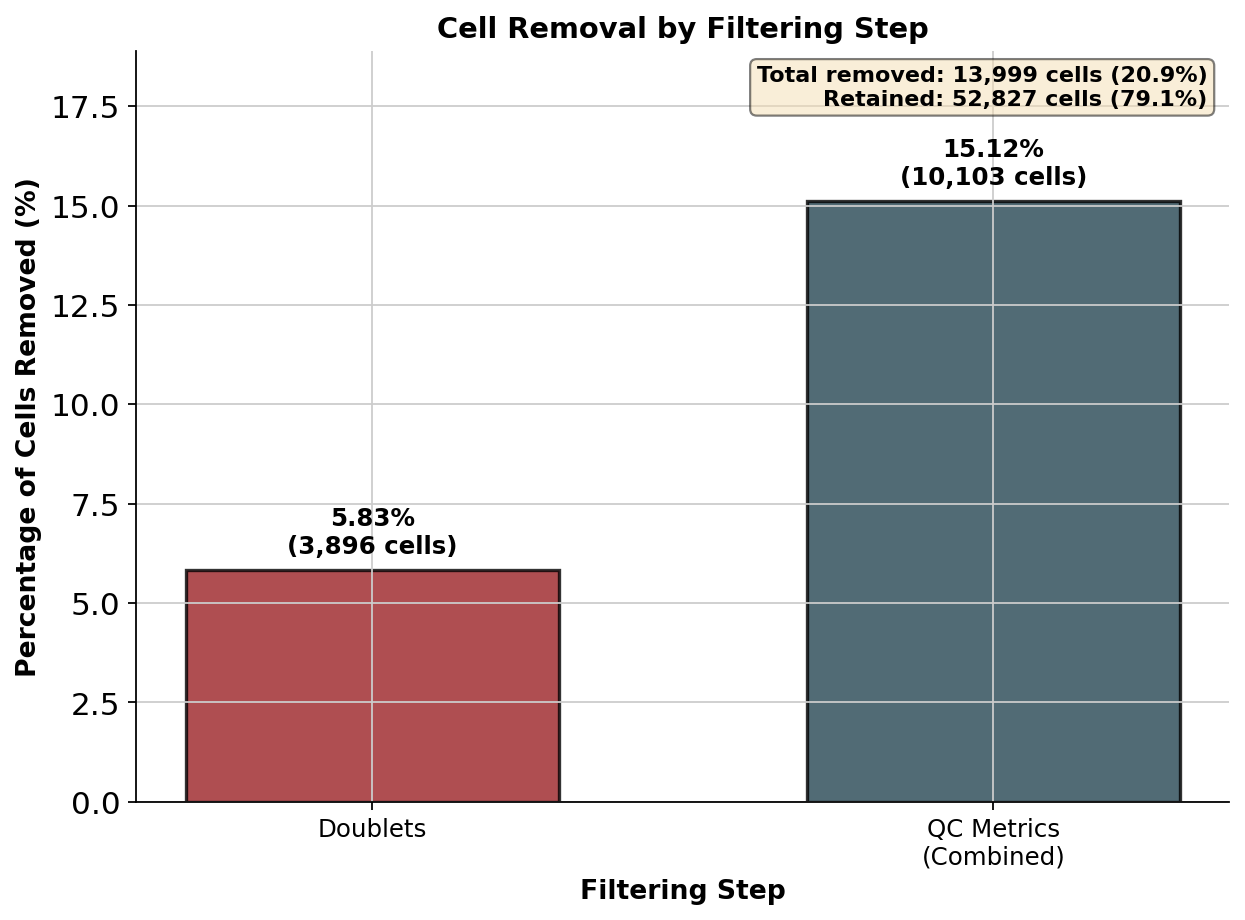


QC FILTERING SUMMARY
Original cells:           66,826
  - Doublets removed:     3,896 (5.83%)
  - QC metrics removed:   10,103 (15.12%)
Final cells retained:     52,827 (79.05%)
Total cells removed:      13,999 (20.95%)


In [ ]:
# @title
# ============================================================
# GROUPED QC IMPACT: Doublets vs Combined QC Metrics
# ============================================================

# Original cells
total_cells_original = 66826

# Doublets removed
doublets_removed = 66826 - 62930  # = 3896

# QC metrics removed (from the 62930 remaining after doublet removal)
qc_removed = 62930 - 52827  # = 10103

# Create grouped breakdown
filter_breakdown = {
    'Doublets': doublets_removed,
    'QC Metrics\n(Combined)': qc_removed,
}

# Convert to percentages (based on original cell count)
filter_breakdown_pct = {k: (v / total_cells_original) * 100 for k, v in filter_breakdown.items()}

# Create bar plot
fig, ax = plt.subplots(figsize=(8, 6))

labels = list(filter_breakdown.keys())
values = list(filter_breakdown_pct.values())
colors = ['#9B2226', '#264653']  # Red for doublets, blue for QC

bars = ax.bar(range(len(labels)), values, color=colors, edgecolor='black',
              linewidth=1.5, alpha=0.8, width=0.6)

# Add values on bars
for idx, (bar, val) in enumerate(zip(bars, values)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.3,
            f'{val:.2f}%\n({filter_breakdown[labels[idx]]:,} cells)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

# Add summary statistics
total_removed = doublets_removed + qc_removed
total_pct = (total_removed / total_cells_original) * 100
ax.text(0.98, 0.98,
        f'Total removed: {total_removed:,} cells ({total_pct:.1f}%)\n'
        f'Retained: {52827:,} cells ({(52827/total_cells_original)*100:.1f}%)',
        transform=ax.transAxes, ha='right', va='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
        fontsize=10, fontweight='bold')

ax.set_ylabel('Percentage of Cells Removed (%)', fontweight='bold', fontsize=12)
ax.set_xlabel('Filtering Step', fontweight='bold', fontsize=12)
ax.set_title('Cell Removal by Filtering Step', fontweight='bold', fontsize=13)
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, fontsize=11)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim(0, max(values) * 1.25)

plt.tight_layout()
plt.show()

# Print summary
print("\n" + "="*60)
print("QC FILTERING SUMMARY")
print("="*60)
print(f"Original cells:           {total_cells_original:,}")
print(f"  - Doublets removed:     {doublets_removed:,} ({(doublets_removed/total_cells_original)*100:.2f}%)")
print(f"  - QC metrics removed:   {qc_removed:,} ({(qc_removed/total_cells_original)*100:.2f}%)")
print(f"Final cells retained:     {52827:,} ({(52827/total_cells_original)*100:.2f}%)")
print(f"Total cells removed:      {total_removed:,} ({total_pct:.2f}%)")
print("="*60)

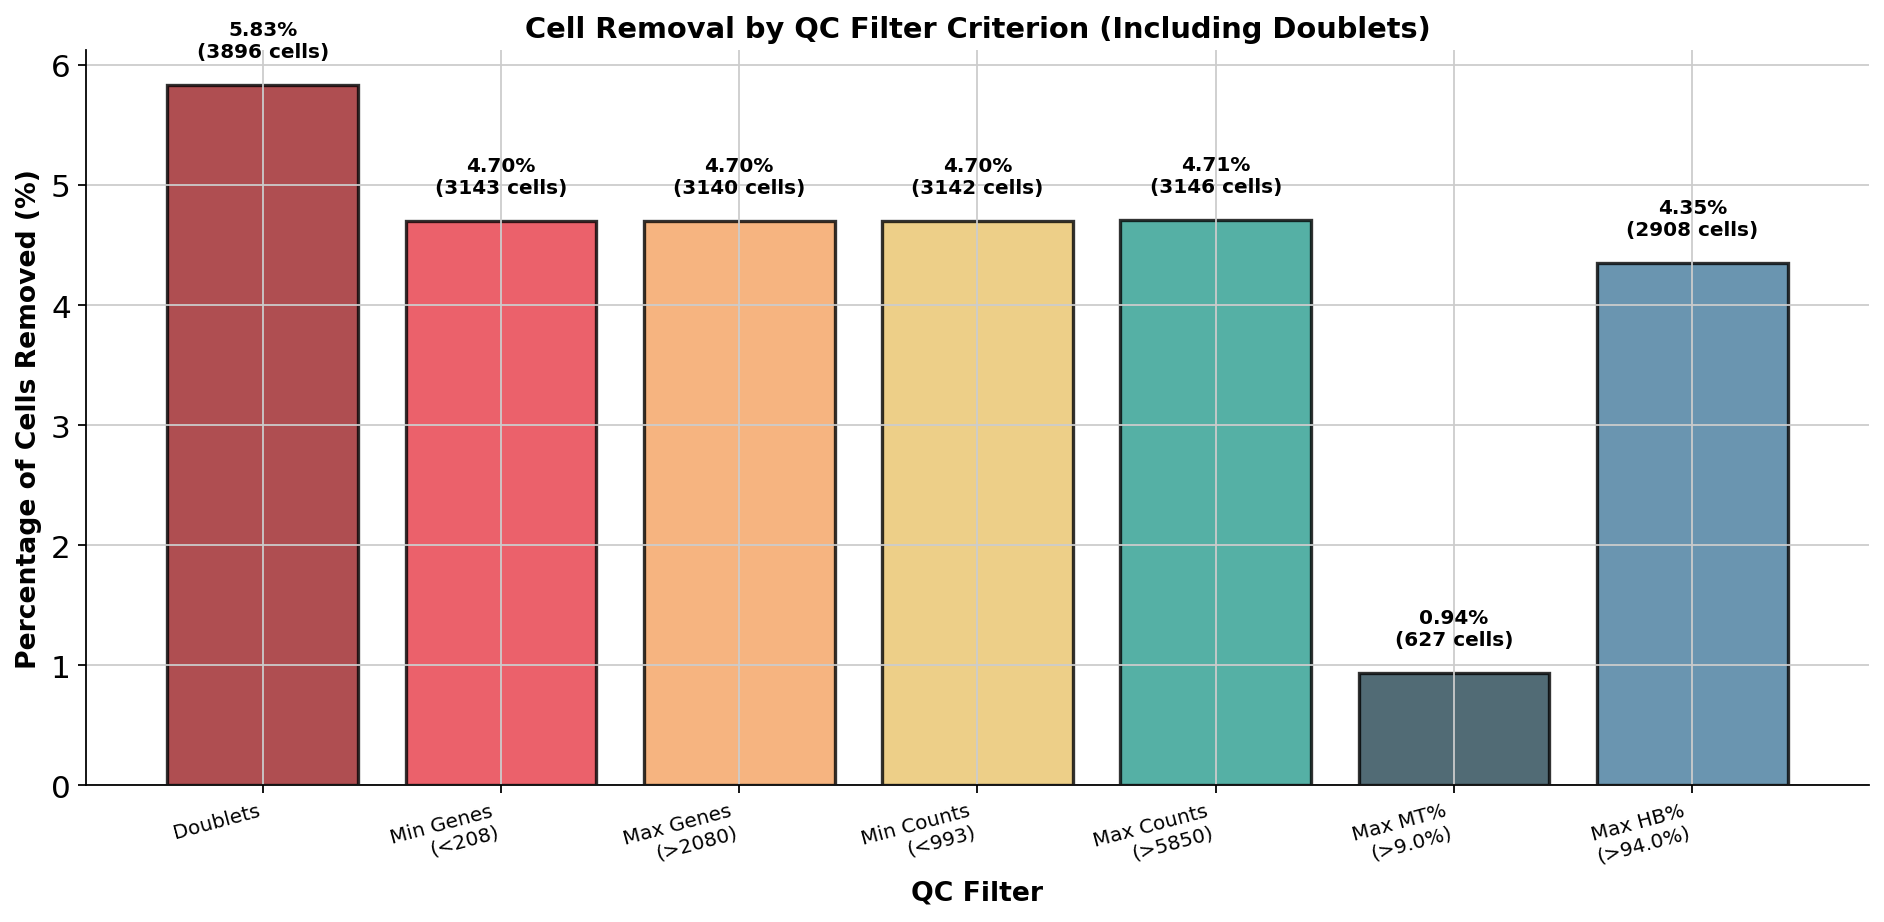

In [ ]:
# @title
# Calculate cells removed by each QC criterion INCLUDING DOUBLETS
filter_breakdown = {
    'Doublets': filtering_stats.get('doublets_removed', 0),  # From doublet removal step
    'Min Genes\n(<{})'.format(filtering_stats['filtering_criteria']['min_genes']):
        sum(adata_concat.obs['n_genes_by_counts'] < filtering_stats['filtering_criteria']['min_genes']),
    'Max Genes\n(>{})'.format(filtering_stats['filtering_criteria']['max_genes']):
        sum(adata_concat.obs['n_genes_by_counts'] > filtering_stats['filtering_criteria']['max_genes']),
    'Min Counts\n(<{})'.format(filtering_stats['filtering_criteria']['min_counts']):
        sum(adata_concat.obs['total_counts'] < filtering_stats['filtering_criteria']['min_counts']),
    'Max Counts\n(>{})'.format(filtering_stats['filtering_criteria']['max_counts']):
        sum(adata_concat.obs['total_counts'] > filtering_stats['filtering_criteria']['max_counts']),
    'Max MT%\n(>{:.1f}%)'.format(filtering_stats['filtering_criteria']['max_mt']):
        sum(adata_concat.obs['pct_counts_mt'] > filtering_stats['filtering_criteria']['max_mt']),
    'Max HB%\n(>{:.1f}%)'.format(filtering_stats['filtering_criteria']['max_hb']):
        sum(adata_concat.obs['pct_counts_hb'] > filtering_stats['filtering_criteria']['max_hb']),
}

# Convert to percentages (based on cells BEFORE any QC)
total_cells_original = adata_concat.n_obs + filtering_stats.get('doublets_removed', 0)
filter_breakdown_pct = {k: (v / total_cells_original) * 100 for k, v in filter_breakdown.items()}

# Create bar plot
fig, ax = plt.subplots(figsize=(12, 6))

labels = list(filter_breakdown.keys())
values = list(filter_breakdown_pct.values())
colors = ['#9B2226', '#E63946', '#F4A261', '#E9C46A', '#2A9D8F', '#264653', '#457B9D']

bars = ax.bar(range(len(labels)), values, color=colors, edgecolor='black', linewidth=1.5, alpha=0.8)

# Add values on bars
for idx, (bar, val) in enumerate(zip(bars, values)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.2,
            f'{val:.2f}%\n({filter_breakdown[labels[idx]]} cells)',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_ylabel('Percentage of Cells Removed (%)', fontweight='bold', fontsize=12)
ax.set_xlabel('QC Filter', fontweight='bold', fontsize=12)
ax.set_title('Cell Removal by QC Filter Criterion (Including Doublets)', fontweight='bold', fontsize=13)
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, fontsize=9, rotation=15, ha='right')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

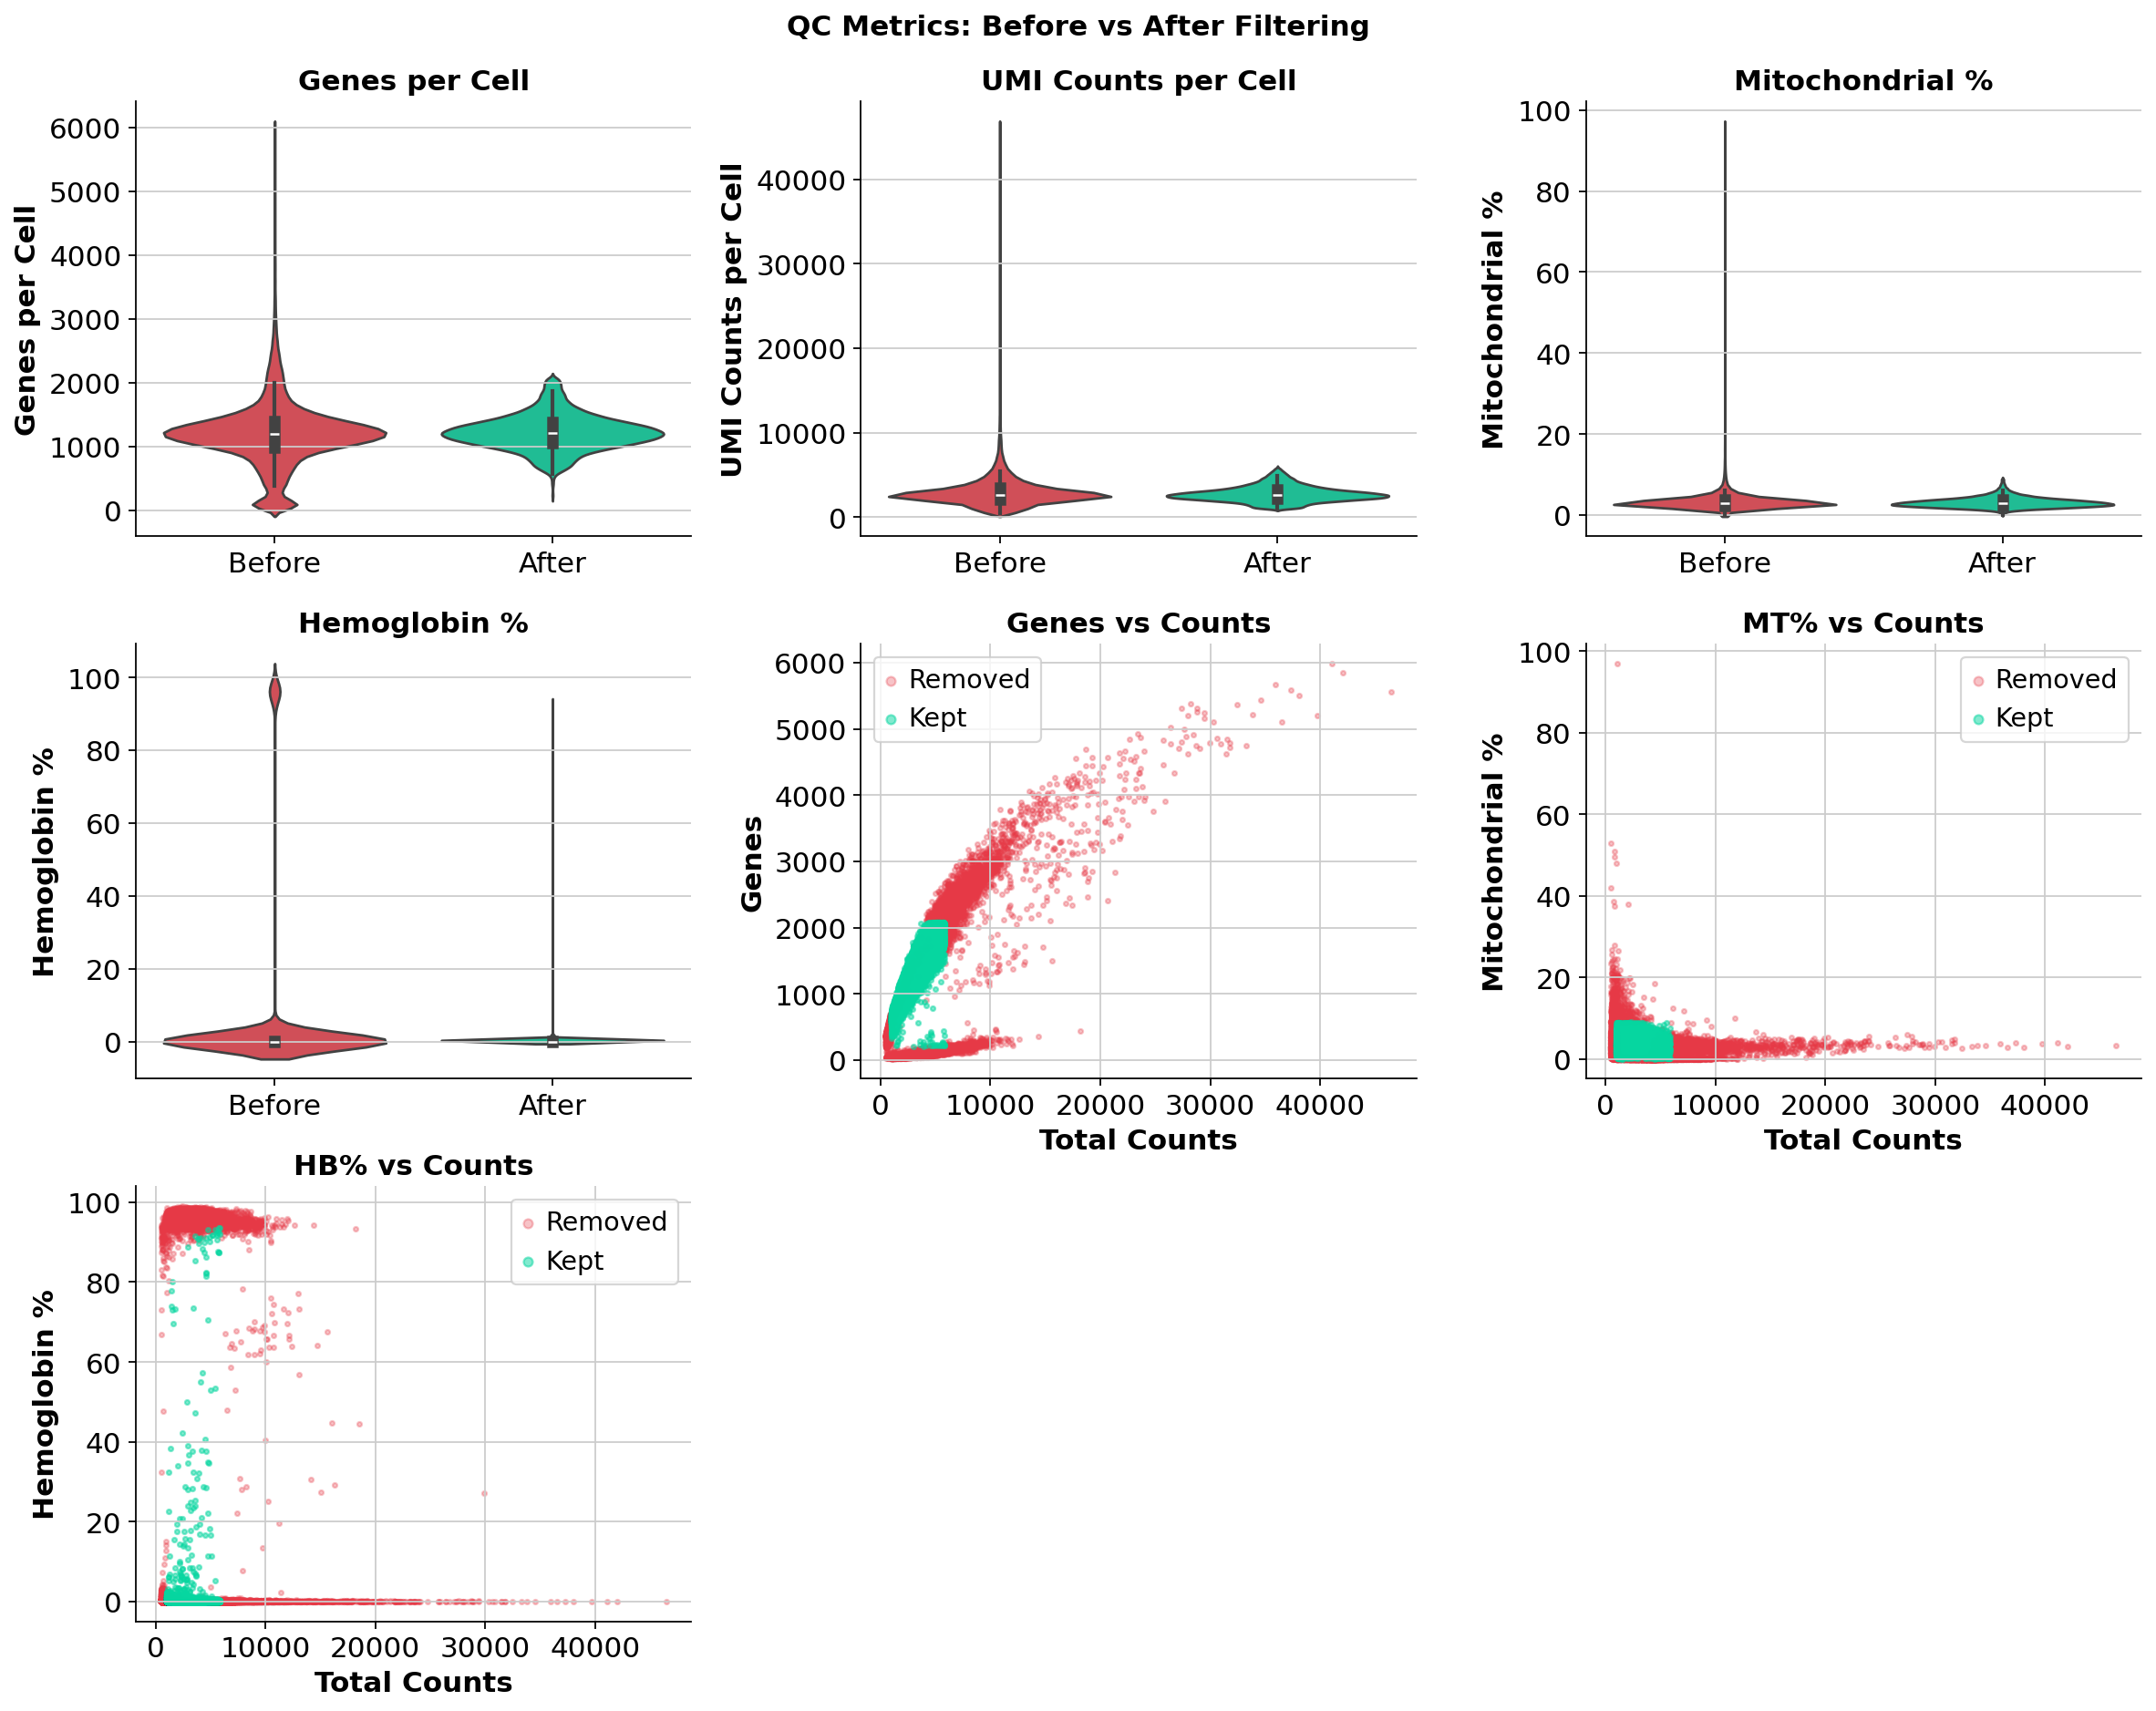

In [ ]:
# @title
# QC violin plots in 3x3 layout
fig, axes = plt.subplots(3, 3, figsize=(15, 12))

# Flatten axes for easier indexing
axes = axes.flatten()

# Metrics to plot
metrics = [
    ('n_genes_by_counts', 'Genes per Cell'),
    ('total_counts', 'UMI Counts per Cell'),
    ('pct_counts_mt', 'Mitochondrial %'),
    ('pct_counts_hb', 'Hemoglobin %')
]

# Plot each metric in the first 4 positions
for idx, (metric, label) in enumerate(metrics):
    ax = axes[idx]

    # Create dataframe for plotting
    before_data = pd.DataFrame({'value': adata_concat.obs[metric], 'QC': 'Before'})
    after_data = pd.DataFrame({'value': adata_filtered.obs[metric], 'QC': 'After'})
    plot_data = pd.concat([before_data, after_data])

    # Violin plot
    sns.violinplot(data=plot_data, x='QC', y='value',
                   palette=['#E63946', '#06D6A0'], ax=ax)

    ax.set_ylabel(label, fontweight='bold')
    ax.set_xlabel('')
    ax.set_title(label, fontweight='bold')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Scatter plots in remaining positions
# Position 4: Genes vs Counts
ax = axes[4]
removed_cells = adata_concat.obs.index.difference(adata_filtered.obs.index)
ax.scatter(adata_concat[removed_cells].obs['total_counts'],
           adata_concat[removed_cells].obs['n_genes_by_counts'],
           c='#E63946', s=5, alpha=0.3, label='Removed')
ax.scatter(adata_filtered.obs['total_counts'],
           adata_filtered.obs['n_genes_by_counts'],
           c='#06D6A0', s=5, alpha=0.5, label='Kept')
ax.set_xlabel('Total Counts', fontweight='bold')
ax.set_ylabel('Genes', fontweight='bold')
ax.set_title('Genes vs Counts', fontweight='bold')
ax.legend(markerscale=2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Position 5: MT% vs Counts
ax = axes[5]
ax.scatter(adata_concat[removed_cells].obs['total_counts'],
           adata_concat[removed_cells].obs['pct_counts_mt'],
           c='#E63946', s=5, alpha=0.3, label='Removed')
ax.scatter(adata_filtered.obs['total_counts'],
           adata_filtered.obs['pct_counts_mt'],
           c='#06D6A0', s=5, alpha=0.5, label='Kept')
ax.set_xlabel('Total Counts', fontweight='bold')
ax.set_ylabel('Mitochondrial %', fontweight='bold')
ax.set_title('MT% vs Counts', fontweight='bold')
ax.legend(markerscale=2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Position 6: HB% vs Counts
ax = axes[6]
ax.scatter(adata_concat[removed_cells].obs['total_counts'],
           adata_concat[removed_cells].obs['pct_counts_hb'],
           c='#E63946', s=5, alpha=0.3, label='Removed')
ax.scatter(adata_filtered.obs['total_counts'],
           adata_filtered.obs['pct_counts_hb'],
           c='#06D6A0', s=5, alpha=0.5, label='Kept')
ax.set_xlabel('Total Counts', fontweight='bold')
ax.set_ylabel('Hemoglobin %', fontweight='bold')
ax.set_title('HB% vs Counts', fontweight='bold')
ax.legend(markerscale=2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Hide remaining empty subplots
for idx in range(7, 9):
    axes[idx].axis('off')

plt.suptitle('QC Metrics: Before vs After Filtering', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# 6 - SAVING PROCESSED DATA

In [ ]:
# Save the filtered AnnData object for the next stage of analysis
output_file = os.path.join(DATA_DIR, OUTPUT_DIR, 'stage1_clean_adata.h5ad')

print(f"Saving filtered data to: {output_file}")
adata_filtered.write(output_file)

print(f"Successfully saved: {adata_filtered.n_obs} cells and {adata_filtered.n_vars} genes.")